
# ROOM OCCUPANCY PROJECT

This is a simple project aiming at estimating the occupancy (count) of a room using data recorded by different sensors (temperature, CO2, sound, light and motion) as a function of time.  
Data are based on a [paper published in IEEE](https://ieeexplore.ieee.org/document/8644432) and can be found on [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation).

We will first try to reproduce the results presented in the paper then to improve the results using feature engineering and by building more complex models.

## Imports

In [65]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearnex import patch_sklearn
patch_sklearn()

from room_occupancy_module import (read_file_df,plot_columns_index_occupancy,plot_onecolumn_index_occupancy,
                                   plot_one_columns_index_occupancy_compare_transformation,print_metrics,plot_confusion_acc_f1)
%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [68]:
# preprocessing
from sklearn.preprocessing import StandardScaler

# model selection
from sklearn.model_selection import GridSearchCV,cross_val_predict,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# modeling
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## Data Collection

Save data from URL to dataframe `df`.

In [3]:
file_path = 'https://archive.ics.uci.edu/static/public/864/room+occupancy+estimation.zip'
df = read_file_df(file_path)

In [4]:
df.head(1)

date  S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  S2_Light  \
0 2017-12-22 10:49:41    24.94    24.75    24.56    25.38       121        34   

   S3_Light  S4_Light  S1_Sound  S2_Sound  S3_Sound  S4_Sound  S5_CO2  \
0        53        40      0.08      0.19      0.06      0.06     390   

   S5_CO2_Slope  S6_PIR  S7_PIR  Room_Occupancy_Count  
0      0.769231       0       0                     1

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  10129 non-null  datetime64[ns]
 1   S1_Temp               10129 non-null  float64       
 2   S2_Temp               10129 non-null  float64       
 3   S3_Temp               10129 non-null  float64       
 4   S4_Temp               10129 non-null  float64       
 5   S1_Light              10129 non-null  int64         
 6   S2_Light              10129 non-null  int64         
 7   S3_Light              10129 non-null  int64         
 8   S4_Light              10129 non-null  int64         
 9   S1_Sound              10129 non-null  float64       
 10  S2_Sound              10129 non-null  float64       
 11  S3_Sound              10129 non-null  float64       
 12  S4_Sound              10129 non-null  float64       
 13  S5_CO2          

All features are numerical and target `Room_Occupacy_Count` is multi-class (int from 0 to 4).

In [6]:
df['Room_Occupancy_Count'].value_counts()

Room_Occupancy_Count
0    8228
2     748
3     694
1     459
Name: count, dtype: int64

Classes are unbalanced, we will need to use stratification stratification and rely on F1-score.

In [7]:
df.isnull().sum()

date                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

No missing data in the dataset, they were removed beforehand by the authors.

### Target Column

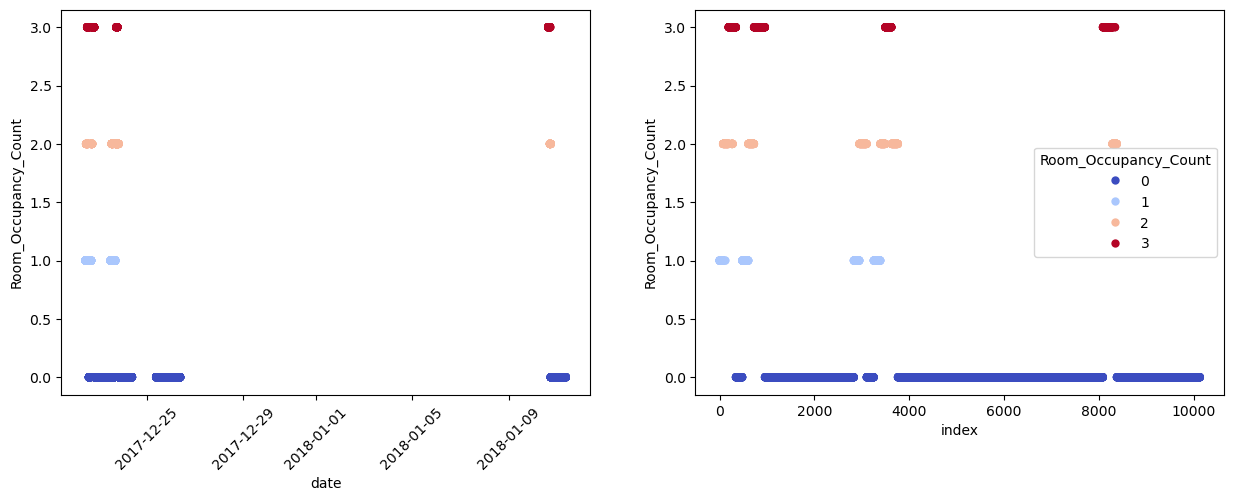

In [8]:
fig,axs = plt.subplots(1,2,figsize = (15,5))
sns.scatterplot(ax=axs[0],data = df, x='date', y='Room_Occupancy_Count', hue = 'Room_Occupancy_Count', palette='coolwarm', edgecolor="none",legend = False)
sns.scatterplot(ax=axs[1],data = df, x=df.index, y='Room_Occupancy_Count', hue = 'Room_Occupancy_Count', palette='coolwarm', edgecolor="none",legend = True)
axs[1].set_xlabel('index')
axs[0].tick_params(axis="x",labelrotation=45);

There is large time gap between two experiments, probably because of the end of the year. Looking at features *vs* index will be more useful. Since we won't be trying to predict a time series, we can safely drop the `date` column.

In [9]:
df= df.drop(columns='date')

## Previous Results

Before attempting to improve the model described in the paper, we will try to reproduce the presented results. To get the best accuracy and f1 score combo, the authors used a SVC with the rbf kernel. They write:  "*Metrics such as accuracy, F1 score and confusion matrix were evaluated using 10-fold cross validation. Since the data is of time-series nature, data was not shuffled prior to cross validation to avoid data points similar to test data getting into the training data*". Macro average was use to compute F1-score. This seems to correspond to what one would get from `cross_val_predict` to find a metric on the whole dataset. 

In [10]:
X = df.copy()
y = X.pop('Room_Occupancy_Count')

In [11]:
X.columns

Index(['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR'],
      dtype='object')

The study does not report the optimal parameters for the SVC classifier, we'll use `GridSearchCV` to figure them out.

In [12]:
svc_pipeline_1 = Pipeline([
    ('std_scaler', StandardScaler()),
    ('svc_rbf', SVC())

])

svc_param_grid_1 = [{
'svc_rbf__C':[1,10,100],
'svc_rbf__gamma':[0.01,0.001,0.0001]
}]

svc_grid_1 = GridSearchCV(svc_pipeline_1,svc_param_grid_1,scoring='f1_macro',cv=10,n_jobs=-1)
svc_grid_1.fit(X,y)
std_svc_best_1 = svc_grid_1.best_estimator_
std_svc_best_1

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Pipeline(steps=[('std_scaler', StandardScaler()),
                ('svc_rbf', SVC(C=10, gamma=0.001))])

The best parameters for `f1_macro` are $C=10$ and $\gamma = 0.001$   which provide A = 0.986 and F1_macro = 0.959.

In [13]:
svc_predictions_1 = cross_val_predict(std_svc_best_1,X,y,cv=10,n_jobs=-1)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


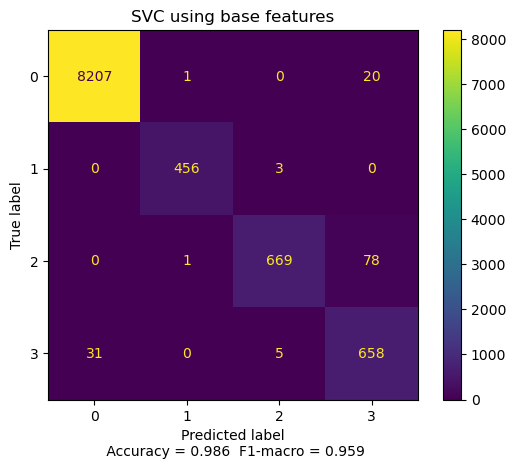

In [14]:
plot_confusion_acc_f1(y,svc_predictions_1,'SVC using base features')

These results are extremely close to the 0.984 accuracy and 0.953 macro f1-score reported in the paper.

## Data Exploration and Feature Engineering

Know, we will attempt to improve the prediction's accuracy and f1 score by:
- Doing some feature engineering
- Tweak the model

Let's first take a close look at the features

In [15]:
X.columns

Index(['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR'],
      dtype='object')

Features can be grouped by sensor types : temperature, light, sound, CO2 level and infrared (PIR). We group the columns names by type: `temp_features`,  `light_features`, `sound_features`,`CO2_features` and `PIR_features` for easy access.

In [16]:
temp_features = ['S1_Temp','S2_Temp','S3_Temp','S4_Temp']
light_features = ['S1_Light','S2_Light','S3_Light','S4_Light']
sound_features = ['S1_Sound','S2_Sound','S3_Sound','S4_Sound']
CO2_features = ['S5_CO2','S5_CO2_Slope']
PIR_features = ['S6_PIR','S7_PIR']

### Temperature features

Let's look at the evolution of the signal from the temperature sensors.

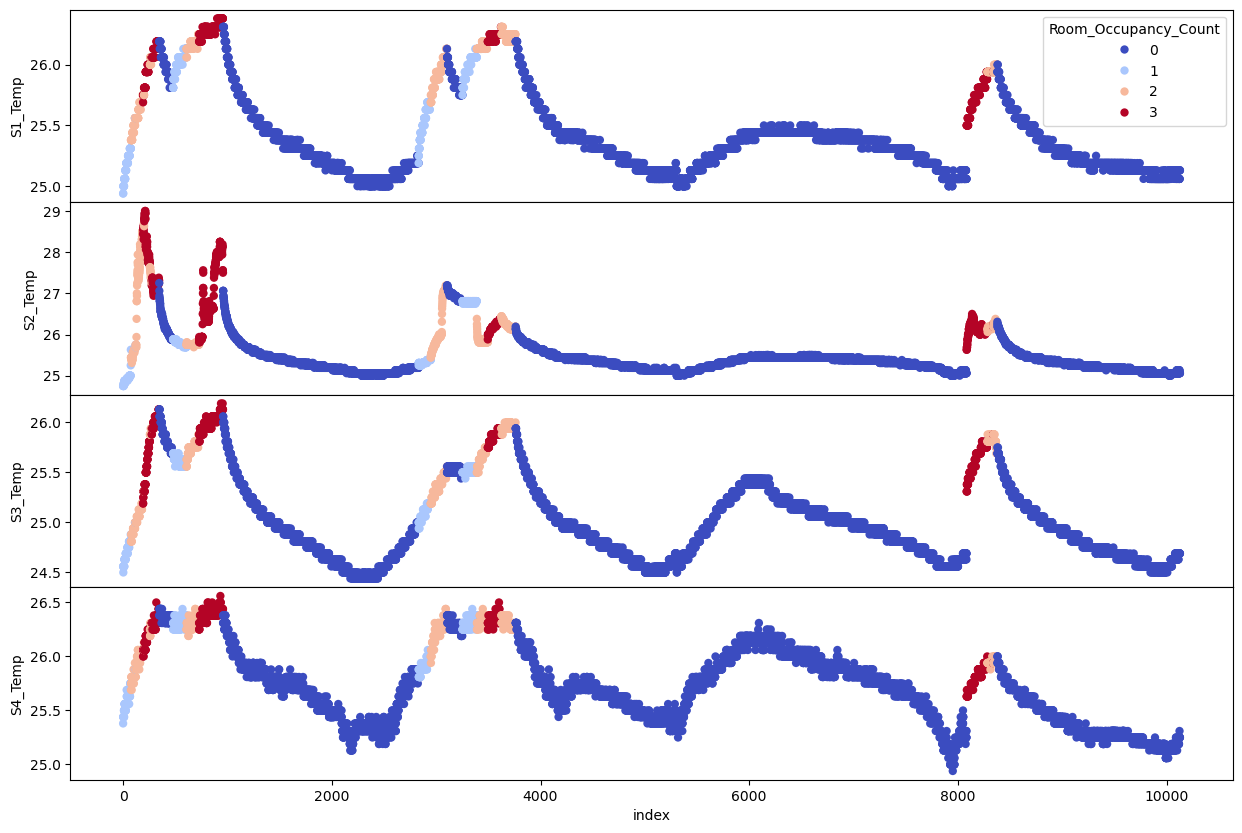

In [17]:
plot_columns_index_occupancy(df,temp_features)

It looks like occupancy has an impact on the rate of change of the temperature, but the overal response depends a lot on history. Maybe the average temperature over the four sensors could be interesting to look at.

We create a new dataframe for the new features we will add: the average sensor response for each sensor type.

In [18]:
df_new_feat = df[['Room_Occupancy_Count']].copy()

Adding a column `avg_temp` representing the average temperature of the four sensors.

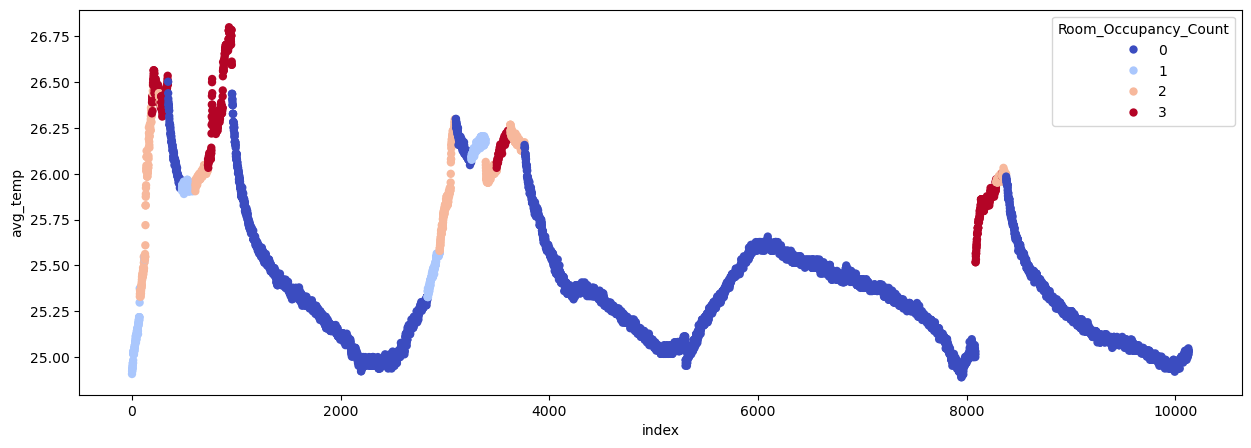

In [19]:
df_new_feat['avg_temp'] = df[temp_features].mean(axis=1).copy()
plot_onecolumn_index_occupancy(df_new_feat,'avg_temp')

### Light features

We do the same for the lights sensors.

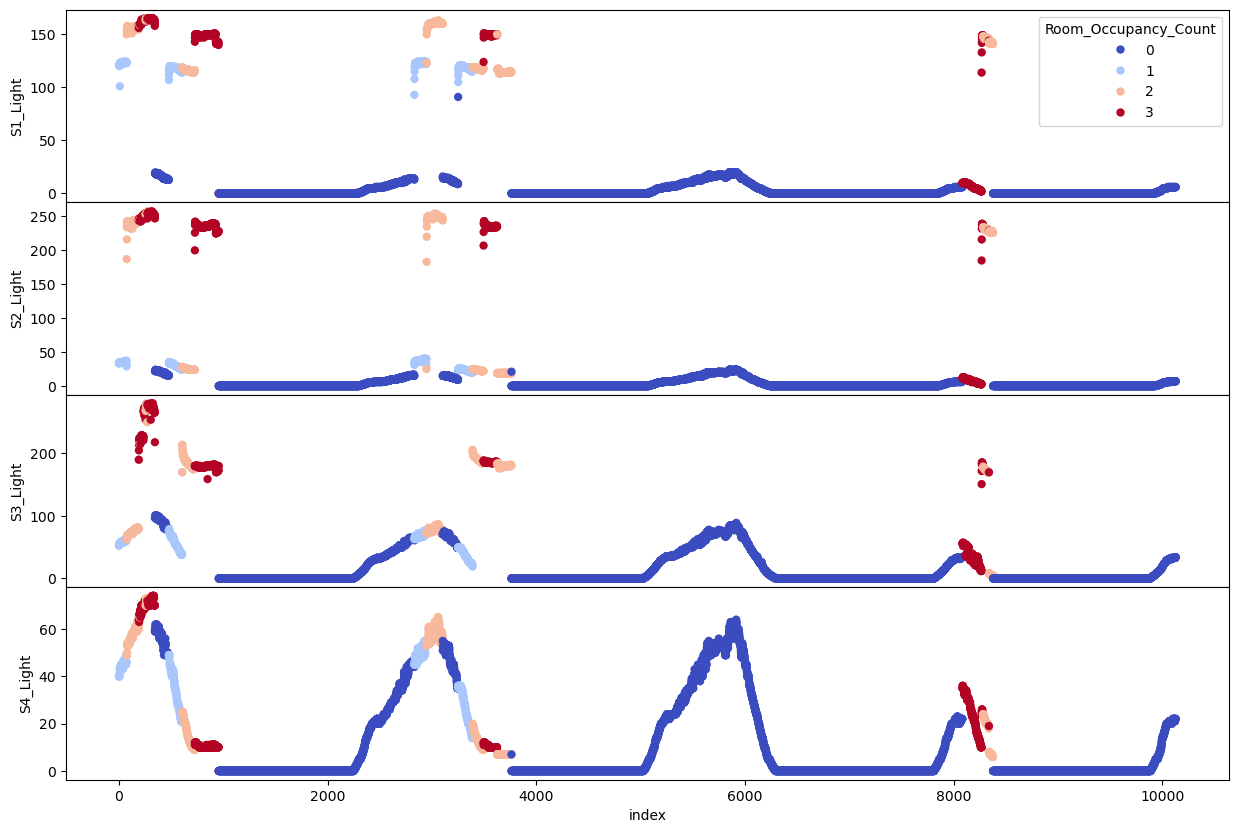

In [20]:
plot_columns_index_occupancy(df,light_features)

Adding a column `avg_light` representing the average light of the four sensors.

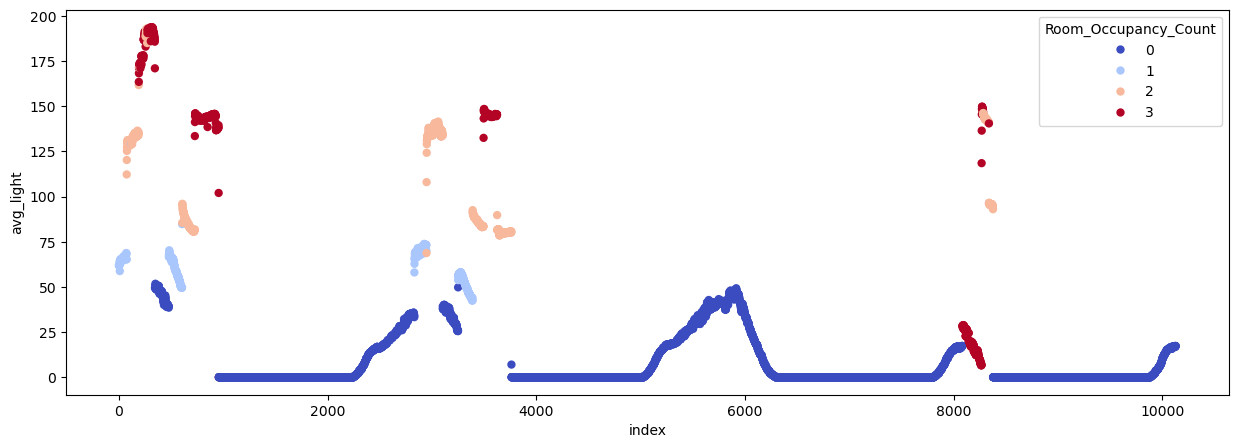

In [21]:
df_new_feat['avg_light'] = df[light_features].mean(axis=1).copy()
plot_onecolumn_index_occupancy(df_new_feat,'avg_light')

Looking at `avg_light`, we can roughly determine the room occupancy by setting threshold values of 50, 100 and 150. This feature will probably help classification.

### Sound Features

Now for the sound features.

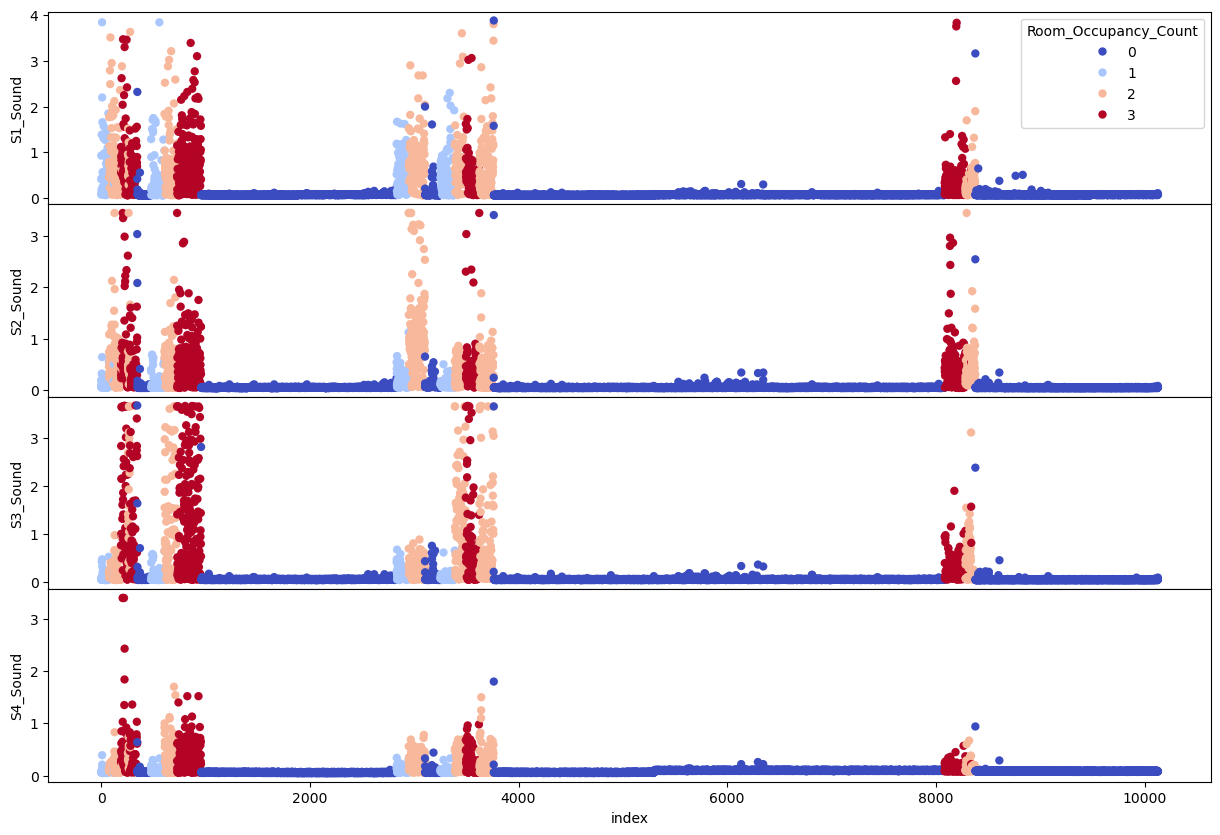

In [22]:
plot_columns_index_occupancy(df,sound_features)

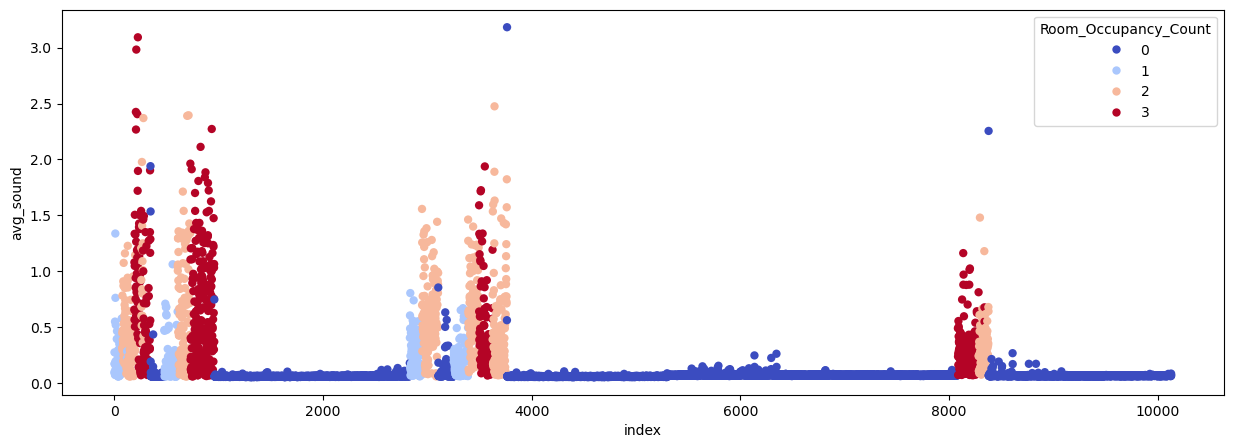

In [23]:
df_new_feat['avg_sound'] = df[sound_features].mean(axis=1).copy()
plot_onecolumn_index_occupancy(df_new_feat,'avg_sound')

### CO2 features

The CO2 slope was extracted using a 25-points sliding window. Since the signal from other sensors is can be quite noisy, ***it may be a good idea to also implement a sliding window average*** to smooth the other sensors response. We will need to implement it through a sk-learn transformer later to prevent data leakage from the sliding window.

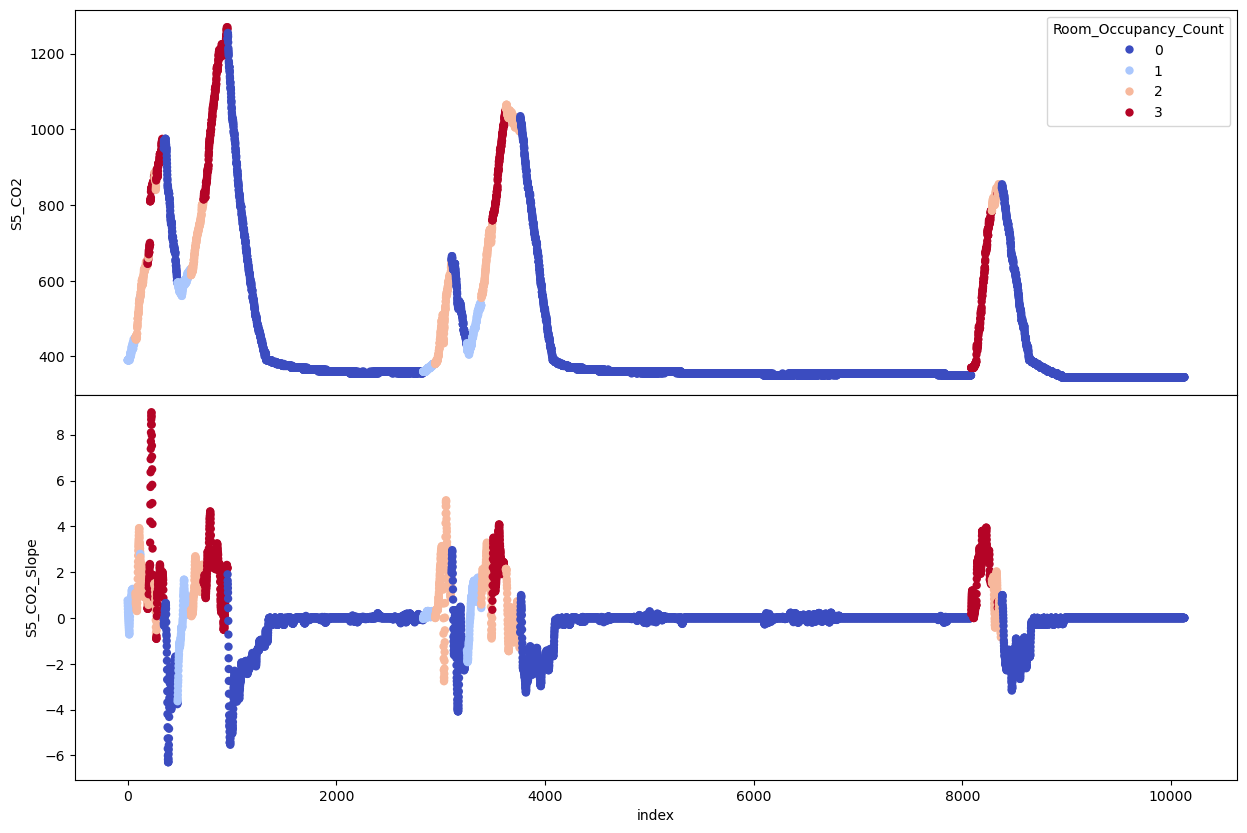

In [24]:
plot_columns_index_occupancy(df,CO2_features)

There are no multiple CO2 sensor signals we can average in this case.

### PIR Features

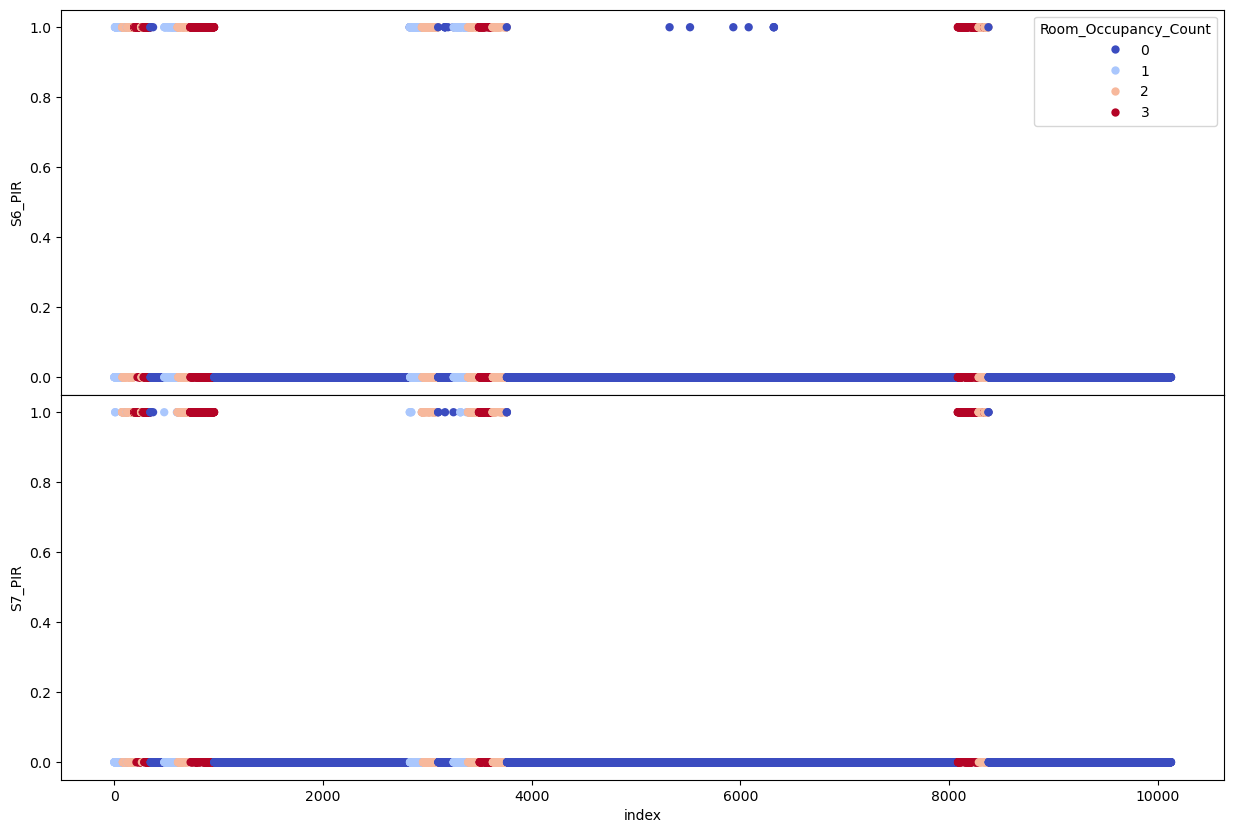

In [25]:
plot_columns_index_occupancy(df,PIR_features)

If we zoom in to see the indices below 1000, we see that the PIR signal fluctuates a lot when the occupancy is non zero. Using an rolling average would probably yeld better prediction power for this feature.

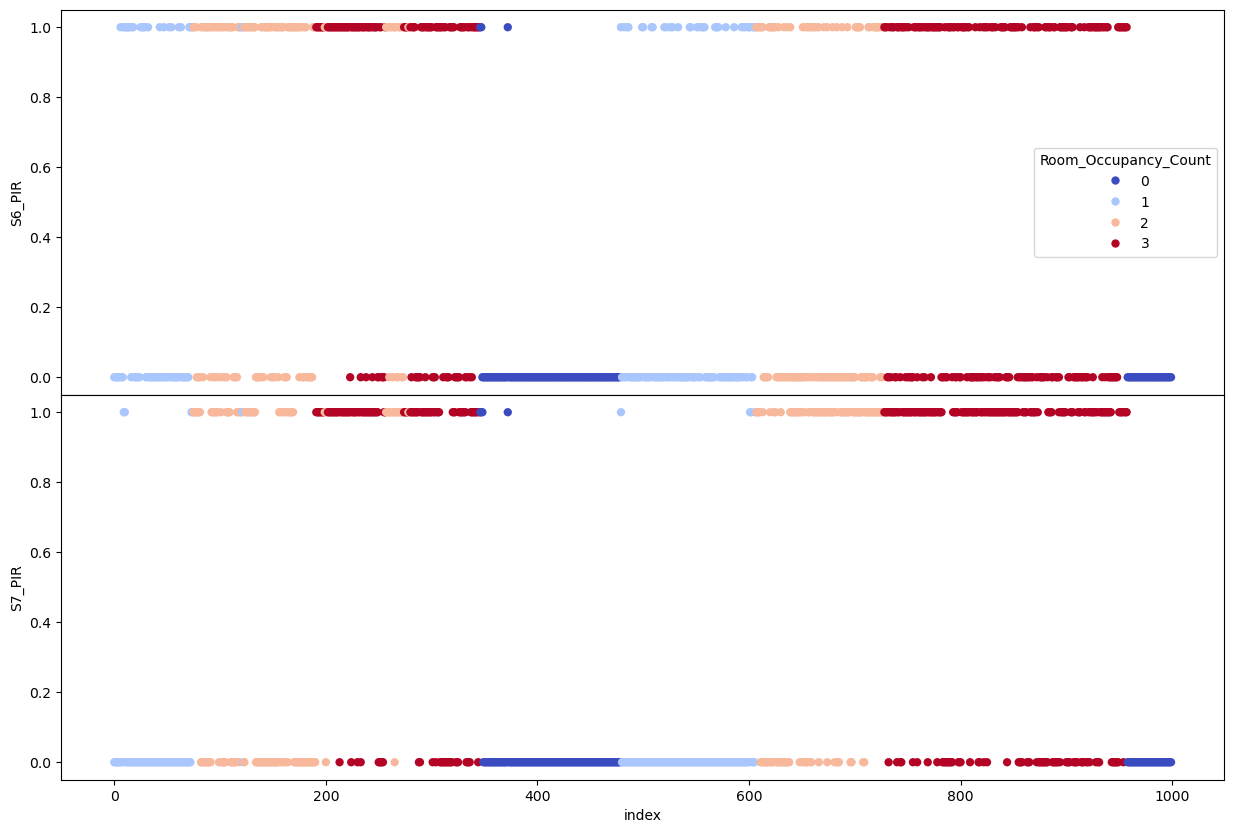

In [26]:
plot_columns_index_occupancy(df.query('index<1000'),PIR_features)

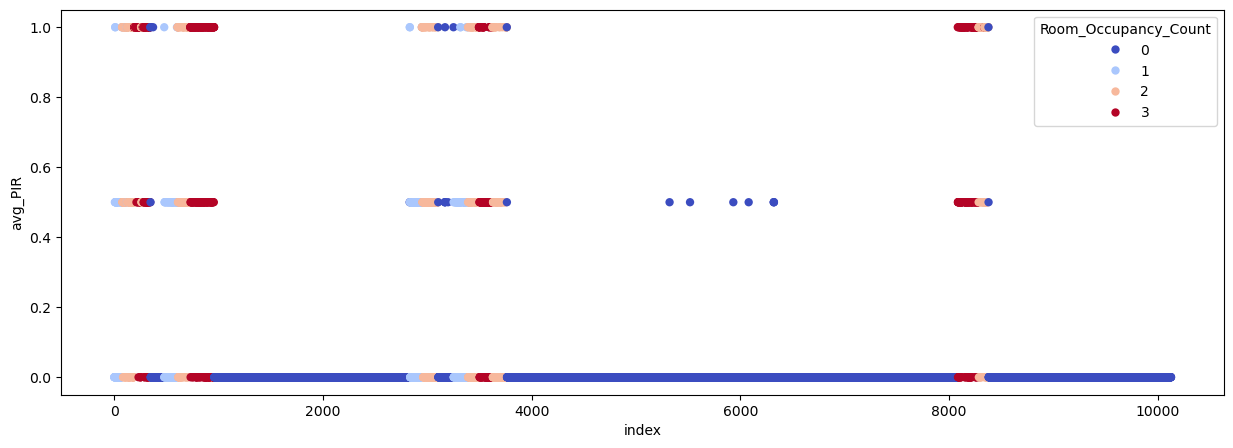

In [27]:
df_new_feat['avg_PIR'] = df[PIR_features].mean(axis=1).copy()
plot_onecolumn_index_occupancy(df_new_feat,'avg_PIR')

### Averaging window

We'll quickly see if using an averaging windows yields significantly different response. This will also impact the target, but we will take car of that during the prober model evaluation.

In [28]:
from transformers import Window_Average

In [29]:
averager = Window_Average(25)

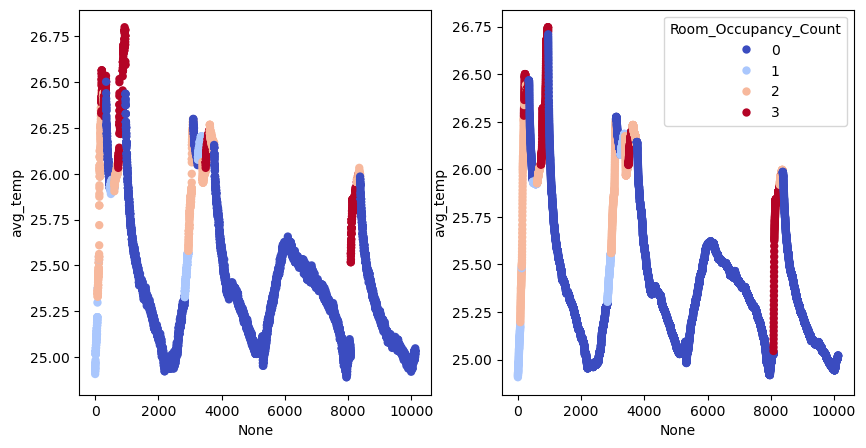

In [30]:
plot_one_columns_index_occupancy_compare_transformation(df_new_feat,'avg_temp',averager)

Left plot shows raw data, right plot shows averaged results.

No significant improvement for temperature.

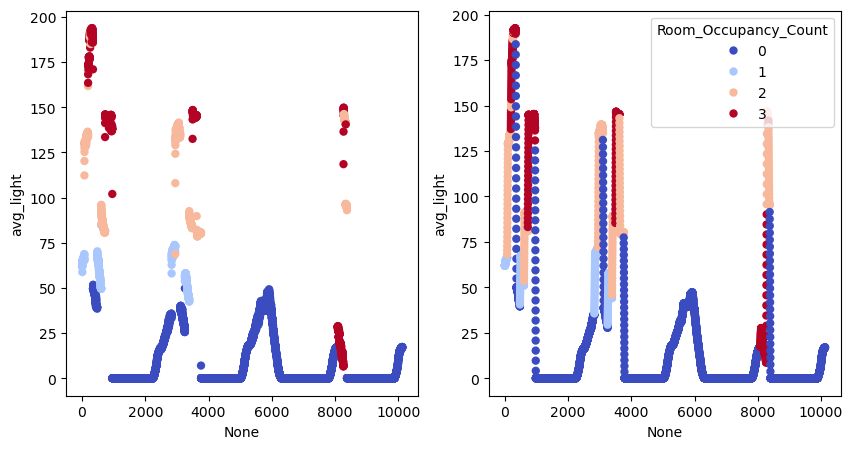

In [31]:
plot_one_columns_index_occupancy_compare_transformation(df_new_feat,'avg_light',averager)

Class separation seems worse for the average light feature.

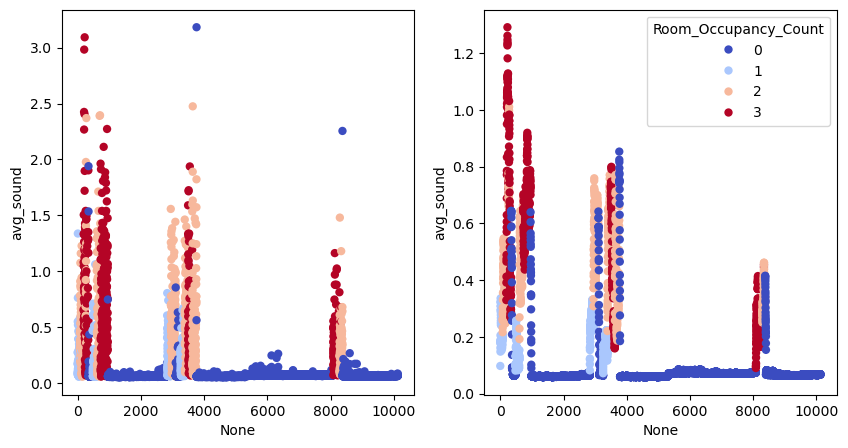

In [32]:
plot_one_columns_index_occupancy_compare_transformation(df_new_feat,'avg_sound',averager)

Sound average seems to be worse as it mixes many  unoccupied states with states with non-zero occupancy.

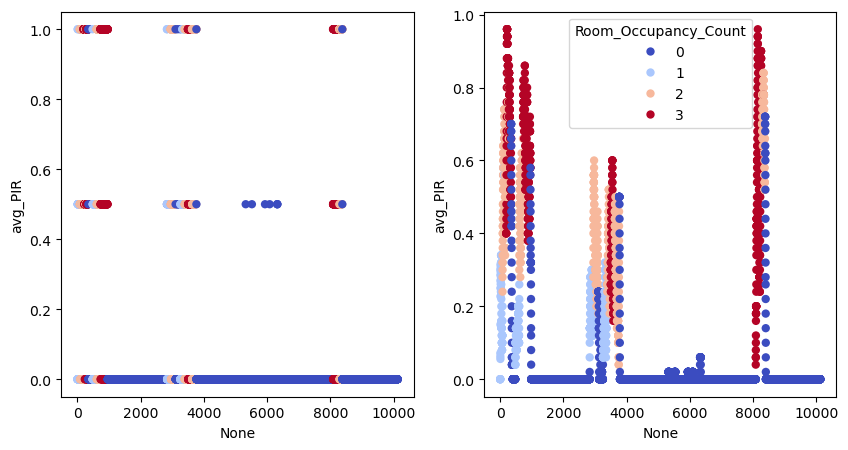

In [33]:
plot_one_columns_index_occupancy_compare_transformation(df_new_feat,'avg_PIR',averager)

Separation seems better for PIR feature with averging window.

### Test of Features

We'll see if the model performs better with the new features (column averages), then we'll try to add the smoothed features.

In [35]:
X_add_new_features = pd.concat([X,df_new_feat.drop(columns='Room_Occupancy_Count')],axis=1)

In [36]:
svc_pipeline_2 = Pipeline([
    ('std_scaler', StandardScaler()),
    ('svc_rbf', SVC())
])

svc_param_grid_2 = [{
'svc_rbf__C':[10,100,1000],
'svc_rbf__gamma':[0.001,0.0001,0.00001]
}]

svc_grid_2 = GridSearchCV(svc_pipeline_2,svc_param_grid_2,scoring='f1_macro',cv=10,n_jobs=-1)
svc_grid_2.fit(X_add_new_features,y)
std_svc_best_2 = svc_grid_2.best_estimator_
std_svc_best_2

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Pipeline(steps=[('std_scaler', StandardScaler()),
                ('svc_rbf', SVC(C=100, gamma=0.0001))])

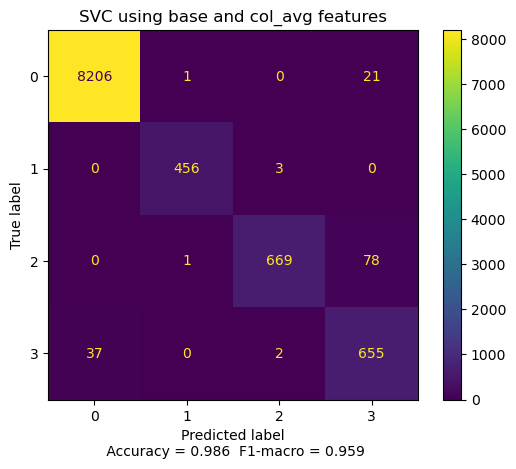

In [37]:
svc_predictions_2 = cross_val_predict(std_svc_best_2,X_add_new_features,y,cv=10,n_jobs=-1)
plot_confusion_acc_f1(y,svc_predictions_2,'SVC using base and col_avg features')

Performances are essentially unchanged. It seems that the column average where not usefull.

### Best SVC

We'll use the smoothed PIR response as it seemed to better separate classes.

In [38]:
X_avg_PIR = pd.concat([X,df_new_feat['avg_PIR']],axis=1)

In [41]:
svc_pipeline_3 = Pipeline([
    ('averager',ColumnTransformer([
         ('avg_PIR',Window_Average(25),['avg_PIR'])],
         remainder='passthrough')),
    ('std_scaler', StandardScaler()),
    ('svc_rbf', SVC())
])

svc_param_grid_3 = [{
'averager__avg_PIR__window_size':[1,25,50],    
'svc_rbf__C':[10],
'svc_rbf__gamma':[0.01]
}]

svc_grid_3 = GridSearchCV(svc_pipeline_3,svc_param_grid_3,scoring='f1_macro',cv=10,n_jobs=-1)
svc_grid_3.fit(X_avg_PIR,y)
std_svc_best_3 = svc_grid_3.best_estimator_
std_svc_best_3

Pipeline(steps=[('averager',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('avg_PIR',
                                                  Window_Average(window_size=25),
                                                  ['avg_PIR'])])),
                ('std_scaler', StandardScaler()),
                ('svc_rbf', SVC(C=10, gamma=0.01))])

Best parameters are :{'averager__avg_PIR__window_size': 25,
 'svc_rbf__C': 10,
 'svc_rbf__gamma': 0.01}

In [43]:
svc_grid_3.best_params_

{'averager__avg_PIR__window_size': 25,
 'svc_rbf__C': 10,
 'svc_rbf__gamma': 0.01}

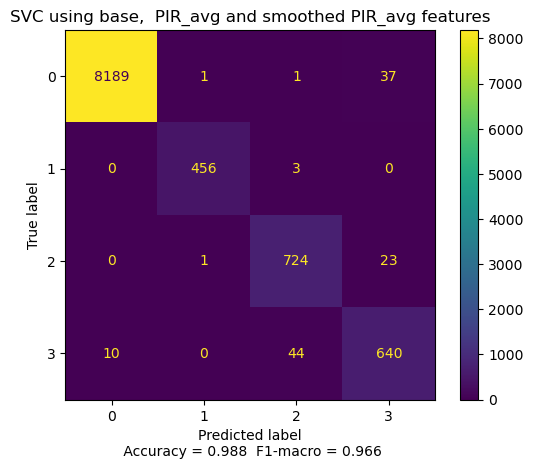

In [44]:
svc_predictions_3 = cross_val_predict(svc_grid_3,X_avg_PIR,y,cv=10,n_jobs=-1)
plot_confusion_acc_f1(y,svc_predictions_3,'SVC using base, PIR_avg and smoothed PIR_avg features')

It looks like adding both `avg_PIR` and smoothed `avg_PIR` increased the prediction slightly.

Let's see if smoothing the two PIR sensors signal also improves prediction.

In [47]:
svc_pipeline_4 = Pipeline([
    ('averager',ColumnTransformer([
         ('avg_PIR',Window_Average(25),['S6_PIR','S7_PIR'])],
         remainder='passthrough')),
    ('std_scaler', StandardScaler()),
    ('svc_rbf', SVC())
])

svc_param_grid_4 = [{
'averager__avg_PIR__window_size':[25],    
'svc_rbf__C':[1,10,100],
'svc_rbf__gamma':[0.1,0.01,0.001]
}]

svc_grid_4 = GridSearchCV(svc_pipeline_4,svc_param_grid_4,scoring='f1_macro',cv=10,n_jobs=-1)
svc_grid_4.fit(X,y)
 = svc_grid_4.best_estimator_
std_svc_best_4

Pipeline(steps=[('averager',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('avg_PIR',
                                                  Window_Average(window_size=25),
                                                  ['S6_PIR', 'S7_PIR'])])),
                ('std_scaler', StandardScaler()),
                ('svc_rbf', SVC(C=10, gamma=0.01))])

In [48]:
std_svc_best_4.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('averager',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('avg_PIR',
                                                  Window_Average(window_size=25),
                                                  ['S6_PIR', 'S7_PIR'])])),
                ('std_scaler', StandardScaler()),
                ('svc_rbf', SVC(C=10, gamma=0.01))])>

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


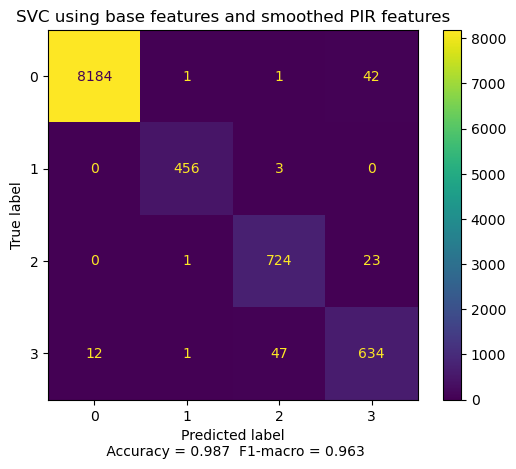

In [49]:
svc_predictions_4 = cross_val_predict(std_svc_best_4,X,y,cv=10,n_jobs=-1)
plot_confusion_acc_f1(y,svc_predictions_4,'SVC using base features and smoothed PIR features')

Only minor improvements compared to avg_PIR results.

## Models

### KNN

In [52]:
knn_pipeline = Pipeline([
    ('averager',ColumnTransformer([
         ('avg_PIR',Window_Average(25),['avg_PIR'])],
         remainder='passthrough')),
    ('std_scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_param_grid = [{
    'knn__n_neighbors':[1,2,3,4,5,6,7,10,50],
    'knn__weights' : ['uniform', 'distance'],
    'knn__p':[1,2]
}]

knn_grid = GridSearchCV(knn_pipeline,knn_param_grid,scoring='f1_macro',cv=10,n_jobs=-1)
knn_grid.fit(X_avg_PIR,y)
std_knn_best_1 = knn_grid.best_estimator_
std_knn_best_1

Pipeline(steps=[('averager',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('avg_PIR',
                                                  Window_Average(window_size=25),
                                                  ['avg_PIR'])])),
                ('std_scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=3))])

In [53]:
std_knn_best_1.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('averager',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('avg_PIR',
                                                  Window_Average(window_size=25),
                                                  ['avg_PIR'])])),
                ('std_scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=3))])>

In [58]:
knn_predictions = cross_val_predict(std_knn_best_1,X_avg_PIR,y,cv=10,n_jobs=-1)

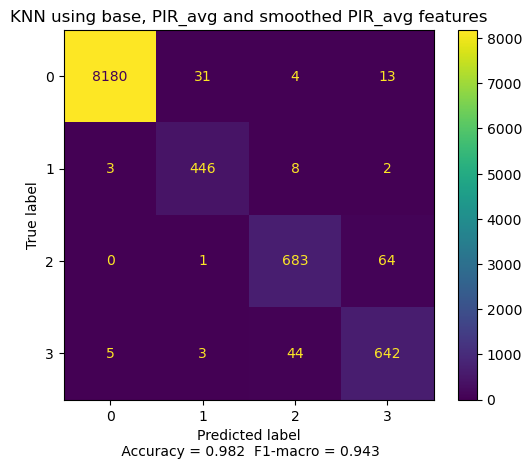

In [59]:
plot_confusion_acc_f1(y,knn_predictions,'KNN using base, PIR_avg and smoothed PIR_avg features')

### Random Forest

In [67]:
rf_pipeline = Pipeline([
    ('averager',ColumnTransformer([
         ('avg_PIR',Window_Average(25),['avg_PIR'])],
         remainder='passthrough')),
    ('std_scaler', StandardScaler()),
    ('rfc', RandomForestClassifier())
])


rf_random_grid = {'rfc__bootstrap': [True, False],
               'rfc__max_depth': [5,10, 20,50, 100, None],
               'rfc__max_features': [1.0, 'sqrt'],
               'rfc__min_samples_leaf': [ 2, 4,8],
               'rfc__min_samples_split': [2, 5, 10],
               'rfc__n_estimators': [100, 200, 500,1000]}

#grid = GridSearchCV(pipeline,param_grid,scoring='f1_macro',cv=10,n_jobs=-1)
rf_grid = RandomizedSearchCV(rf_pipeline, rf_random_grid, n_iter = 200, cv = 10, n_jobs = -1,verbose=1)
rf_grid.fit(X_avg_PIR,y)
std_rf_best = rf_grid.best_estimator_
std_rf_best

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


Pipeline(steps=[('averager',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('avg_PIR',
                                                  Window_Average(window_size=25),
                                                  ['avg_PIR'])])),
                ('std_scaler', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(min_samples_leaf=8,
                                        min_samples_split=5))])

In [69]:
rf_grid.best_params_

{'rfc__n_estimators': 100,
 'rfc__min_samples_split': 5,
 'rfc__min_samples_leaf': 8,
 'rfc__max_features': 'sqrt',
 'rfc__max_depth': None,
 'rfc__bootstrap': True}

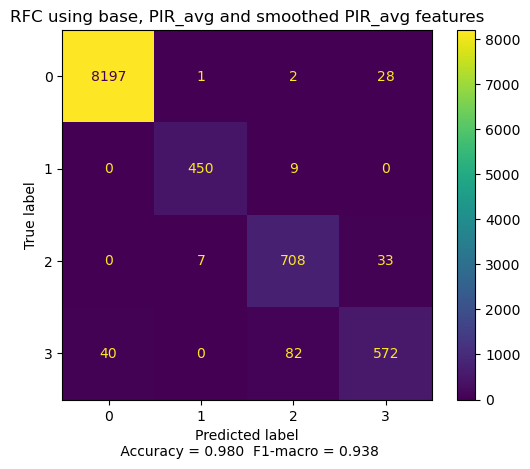

In [70]:
rf_predictions = cross_val_predict(std_rf_best,X_avg_PIR,y,cv=10,n_jobs=-1)
plot_confusion_acc_f1(y,rf_predictions,'RFC using base, PIR_avg and smoothed PIR_avg features')

### XGBoost model

In [703]:
xgb_pipeline= Pipeline([
    ('averager',ColumnTransformer([
        ('w_PIR',Window_Average(25),PIR_features)],
        remainder='passthrough')),
   ('scaler', StandardScaler()),
   ('xgb', XGBClassifier(objective = 'multi:softmax',num_class=4))
   ])

In [645]:
xgb_params_grid = { 
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.001, 0.01, 0.1, ],
    # "xgb__gamma":[0, 0.25, 0.5, 0.75,1],
    'xgb__n_estimators': [100, 500, 1000],
    # "xgb__subsample":[0.9],
    # "xgb__colsample_bytree":[0.5],
    # "xgb__early_stopping_rounds": [10], 
}

xgb_grid = GridSearchCV(
    estimator = xgb_pipeline,
    param_grid = xgb_params_grid,
    scoring = 'f1_macro',
    n_jobs = -1,
    cv = 10,
    verbose = 1,
)

# Model fitting
xgb_grid_fit = xgb_grid.fit(X_avg_PIR,y)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


took 12 minutes to run, with 27 candidates.

In [704]:
std_xgb_best = xgb_grid_fit.best_estimator_

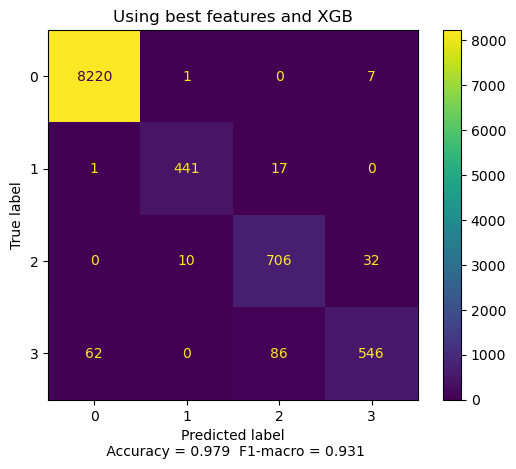

In [705]:
xgb_predictions = cross_val_predict(std_xgb_best,X_avg_PIR,y,cv=10)
plot_confusion_acc_f1(y,xgb_predictions,'XGB using base, PIR_avg and smoothed PIR_avg features')

### LGBM

In [84]:
lgbm_pipeline= Pipeline([
    ('averager',ColumnTransformer([
        ('w_PIR',Window_Average(25),PIR_features)],
        remainder='passthrough')),
   ('scaler', StandardScaler()),
   ('lgbm', LGBMClassifier())
   ])

lgbm_param_grid =  {
    'lgbm__num_leaves': [31,100],
    'lgbm__max_depth': [-1,5],
    'lgbm__learning_rate' : [0.1,0.05],
    'lgbm__n_estimators': [100,50]
    }

In [85]:
lgbm_grid = GridSearchCV(
    estimator = lgbm_pipeline,
    param_grid = lgbm_param_grid,
    scoring = 'f1_macro',
    n_jobs = -1,
    cv = 10,
    verbose = 1,
)
lgbm_grid_fit = lgbm_grid.fit(X_avg_PIR,y)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1534
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 17
[LightGBM] [Info] Start training from score -0.207876
[LightGBM] [Info] Start training from score -3.094339
[LightGBM] [Info] Start training from score -2.606041
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1548
[LightGBM] [Info] Start training from score -2.680035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if mem

In [87]:
print(lgbm_grid_fit.best_params_)

{'lgbm__learning_rate': 0.05, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 31}


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1482
[LightGBM] [Info] Number of data points in the train set: 9116, number of used features: 17
[LightGBM] [Info] Start training from score -0.207741
[LightGBM] [Info] Start training from score -3.094339
[LightGBM] [Info] Start training from score -2.606041
[LightGBM] [Info] Start training from score -2.681636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

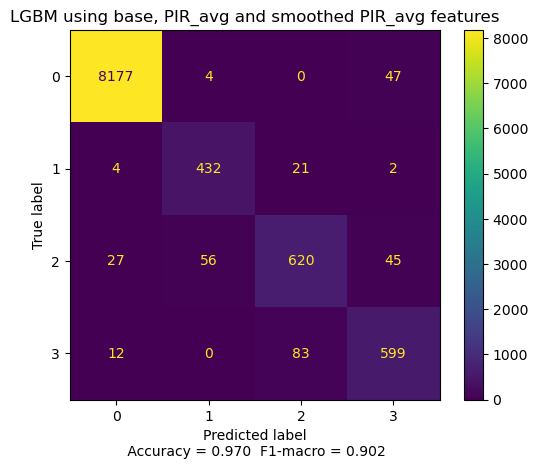

In [88]:
lgbm_predictions = cross_val_predict(lgbm_pipeline,X_avg_PIR,y,cv=10)
plot_confusion_acc_f1(y,lgbm_predictions,'LGBM using base, PIR_avg and smoothed PIR_avg features')

### LDA

In [701]:
lda_pipeline= Pipeline([
    ('averager',ColumnTransformer([
        ('w_PIR',Window_Average(25),PIR_features)],
        remainder='passthrough')),
   ('scaler', StandardScaler()),
   ('lda', LinearDiscriminantAnalysis())
   ])


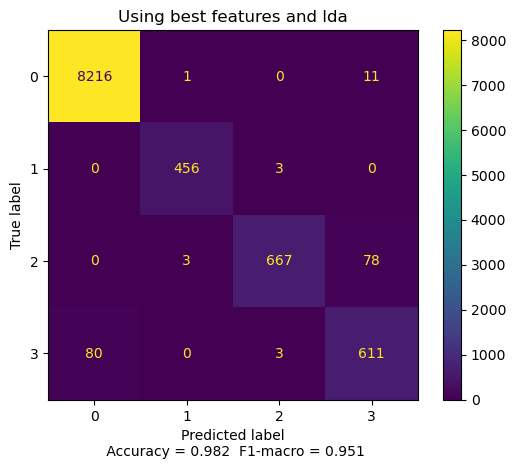

In [702]:
lda_predictions = cross_val_predict(lda_pipeline,X_avg_PIR,y,cv=10)
plot_confusion_acc_f1(y,lda_predictions,'LDA using base, PIR_avg and smoothed PIR_avg features')

### Voting classifier using best results

In [697]:
vc = VotingClassifier([('SVC',std_svc_best),('knn',std_knn_best),('rff',std_rff_best),('xgb',std_xgb_best),('lda',lda)],voting='hard')

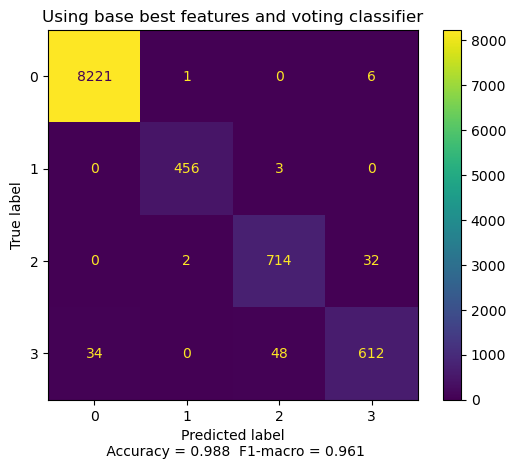

In [698]:
predictions = cross_val_predict(vc,X_avg_PIR,y,cv=10,n_jobs=-1)
plot_confusion_acc_f1(y,predictions,'Voting Classifier using base, PIR_avg and smoothed PIR_avg features')